Load " titanic_data". Survived as your y variable, and the other variables as your x variables. The goal is to build a model to predict whether a person survives or not. 


In [63]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
#import the data
data=pd.read_csv("/content/drive/MyDrive/DataMining/Files/titanic_data.csv")
#explore the data
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

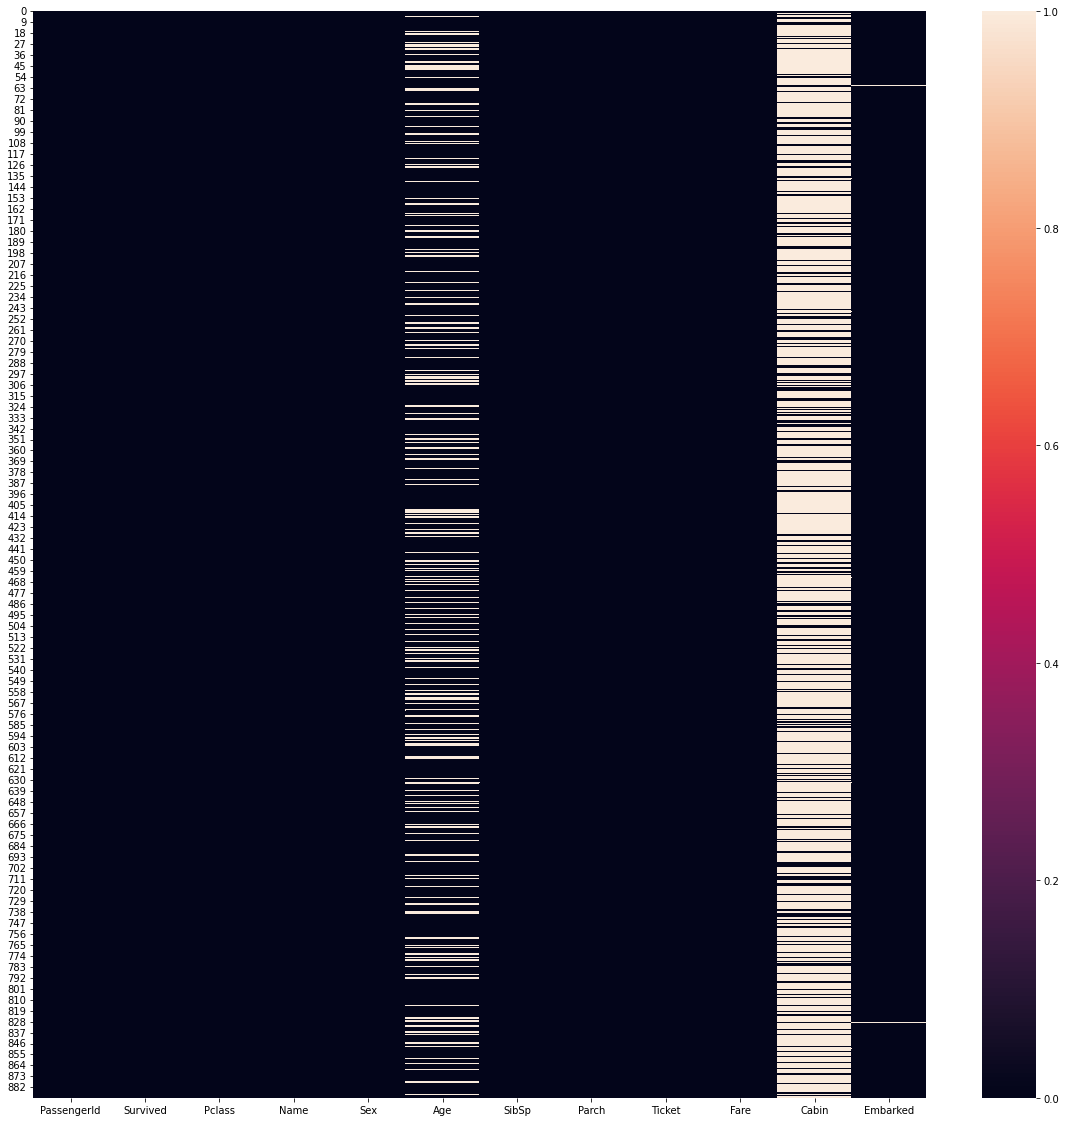

In [93]:
#Hitmap to check the null or drop columns
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(data.isnull()) ##to visualize the missing values
data.isnull().sum()

The data.info() indicates that three colums lack some data and may require some data wrangling, if possible. - Age : 177 values missing (likely) - Cabin : 687 values missing (unlikely) - Embarked : 2 values missing (easy)

In [67]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen \Carrie\""""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [68]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The provides two immediate observations:

Survival rate: only 38% of the 891 passengers survived

Age: the average age of all passengers was 29.7 years with a strong StDev of 14.5 years

The data is about the Titanic passengers. The goal is to predict whether a passenger survives or not (1/0).
The dataset provides the titanic passenger information. It includes 891 records and 12 fields. 
Input Variables: 

 survival:(Numeric)     Survival    0 = No, 1 = Yes
Name: (Categorical)    Name of the person
pclass: (Numeric)   Ticket class    1 = 1st, 2 = 2nd, 3 = 3rd
sex:  (Categorical)       Sex Male or Female   
Age:  ( Numeric)       Age in years    
sibsp: (Numeric)  number of siblings / spouses aboard the Titanic    
parch: (Numeric)   number of parents / children aboard the Titanic    
ticket:  (Categorical)  Ticket number    
fare:    (Numeric)    Passenger fare    
cabin:   (Categirical) Cabin number    
embarked:  (Categorical) Port of Embarkation    C = Cherbourg, Q = Queenstown, S = Southampton


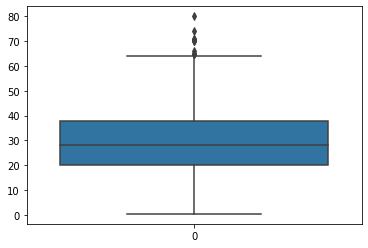

In [94]:
#Cleaning Dataset, dropped 'Ticket' and 'Cabin' for our prediction model as they might have zero or low influence on 'Survived'
data=data.drop(["Ticket", "Cabin"],axis=1)
sns.boxplot(data=data["Age"])
median_age=data["Age"].median()
data["Age"]=data["Age"].fillna(median_age)
data["Embarked"].value_counts()
data["Embarked"] = data["Embarked"].fillna("S")

In [95]:
#1. Can some important info be extracted from the name column? Use that in your models.
"""Yes, the titles can be extracted from the name column"""
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [96]:
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [97]:
data=data.drop(['PassengerId','Name'], axis=1)

In [12]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Rare
887,1,1,female,19.0,0,0,30.0000,S,Miss
888,0,3,female,28.0,1,2,23.4500,S,Miss
889,1,1,male,26.0,0,0,30.0000,C,Mr


In [98]:
#create dummy variables
#['Sex','Embarked','Title']
temp=pd.get_dummies(data[['Sex','Embarked','Title']], drop_first=True)
data=data.drop(['Sex','Embarked','Title'],axis=1)
data = pd.concat([data,temp],axis=1)

#Separate the x and y variables
x=data.drop(["Survived"],axis=1)
y=data['Survived'] # Survive is the y column

In [75]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [99]:
##train and test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

In [100]:
x_train

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
520,1,30.0,0,0,93.5000,0,0,1,1,0,0,0
510,3,29.0,0,0,7.7500,1,1,0,0,1,0,0
446,2,13.0,0,1,19.5000,0,0,1,1,0,0,0
2,3,26.0,0,0,7.9250,0,0,1,1,0,0,0
691,3,4.0,0,1,13.4167,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
575,3,19.0,0,0,14.5000,1,0,1,0,1,0,0
838,3,32.0,0,0,56.4958,1,0,1,0,1,0,0
337,1,41.0,0,0,134.5000,0,0,0,1,0,0,0
523,1,44.0,0,1,57.9792,0,0,0,0,0,1,0


In [16]:
#2 Fit a logistic regression model. 
# Show precision, recall, F-score, and confusion matrix and interpret the results.

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [102]:
len(y_pred)

268

In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[137  17]
 [ 37  77]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       154
           1       0.82      0.68      0.74       114

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.79       268



In [104]:
#3. Try Linear Regression here
#Separate the x and y variables
x=data.drop(["Survived"],axis=1)
y=data['Survived'] 

## Train and test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(x_train,y_train)


LinearRegression()

In [105]:
x_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
331,1,45.5,0,0,28.5000,1,0,1,0,1,0,0
700,1,18.0,1,0,227.5250,0,0,0,0,0,1,0
748,1,19.0,1,0,53.1000,1,0,1,0,1,0,0
751,3,6.0,0,1,12.4750,1,0,1,0,0,0,0
481,2,28.0,0,0,0.0000,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,3,28.0,0,0,7.7292,1,1,0,0,1,0,0
416,2,34.0,1,1,32.5000,0,0,1,0,0,1,0
407,2,3.0,1,1,18.7500,1,0,1,0,0,0,0
482,3,50.0,0,0,8.0500,1,0,1,0,1,0,0


In [106]:
predictions = lm.predict(x_test)

len(predictions)

268

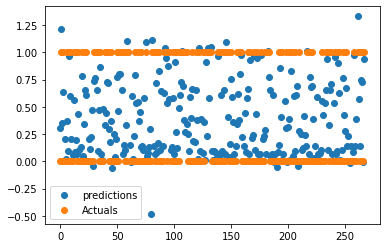

In [107]:
x_test_plt=np.arange(0,len(x_test),1)

import matplotlib.pyplot as plt
plt.scatter(x_test_plt,predictions,label="predictions")
plt.scatter(x_test_plt,y_test,label="Actuals")
plt.legend()

We can not do linear regression here as the prediction values are not between 0 and 1

In [108]:
#4. Build KNN Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline  
from sklearn.metrics import (f1_score,confusion_matrix,
                             precision_score,recall_score, classification_report)
pipe = Pipeline([('a', MinMaxScaler()), ('b', KNeighborsClassifier())])


In [109]:
x_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
331,1,45.5,0,0,28.5000,1,0,1,0,1,0,0
700,1,18.0,1,0,227.5250,0,0,0,0,0,1,0
748,1,19.0,1,0,53.1000,1,0,1,0,1,0,0
751,3,6.0,0,1,12.4750,1,0,1,0,0,0,0
481,2,28.0,0,0,0.0000,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,3,28.0,0,0,7.7292,1,1,0,0,1,0,0
416,2,34.0,1,1,32.5000,0,0,1,0,0,1,0
407,2,3.0,1,1,18.7500,1,0,1,0,0,0,0
482,3,50.0,0,0,8.0500,1,0,1,0,1,0,0


In [110]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('a', MinMaxScaler()), ('b', KNeighborsClassifier())])

In [111]:
x_test

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
331,1,45.5,0,0,28.5000,1,0,1,0,1,0,0
700,1,18.0,1,0,227.5250,0,0,0,0,0,1,0
748,1,19.0,1,0,53.1000,1,0,1,0,1,0,0
751,3,6.0,0,1,12.4750,1,0,1,0,0,0,0
481,2,28.0,0,0,0.0000,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,3,28.0,0,0,7.7292,1,1,0,0,1,0,0
416,2,34.0,1,1,32.5000,0,0,1,0,0,1,0
407,2,3.0,1,1,18.7500,1,0,1,0,0,0,0
482,3,50.0,0,0,8.0500,1,0,1,0,1,0,0


In [112]:
y_pred_pipe=pipe.predict(x_test)

In [35]:
y_pred_pipe

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,

In [113]:
c_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_pipe,labels=[0,1]), 
                                     index=['true:0', 'true:1'],  columns=['pred:0', 'pred:1'] )
print (c_matrix)

        pred:0  pred:1
true:0     137      17
true:1      42      72


For KNN model:

- True negative is 137, means predict a passenger is not survived when
the passenger is actually not survived
- False positive  is 17, means predict a passenger is survived when 
the passenger is actually survived
- False negative is 42, means predict a passenger is not survived when 
the passenger is actually survived
- True positive is 72, means predict a passenger is survived when 
the passenger is actually survived


In [115]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
from math import sqrt


In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_x_test=scaler.transform(x_test)
scaled_x_train=scaler.transform(x_train)

In [118]:
##5. Grid Search for optimal solution

from sklearn.model_selection import GridSearchCV
model = KNeighborsRegressor()
grid_params = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsRegressor(),
                  grid_params,
                  verbose=1,
                  cv=3,
                  n_jobs=-1)

gs_results = gs.fit(scaled_x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [119]:
scaled_x_test

array([[0.        , 0.61266649, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.23892362, 0.125     , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.25251427, 0.125     , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.5       , 0.03506388, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.67382441, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.8369122 , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
 9   Title_Miss  891 non-null    uint8  
 10  Title_Mr    891 non-null    uint8  
 11  Title_Mrs   891 non-null    uint8  
 12  Title_Rare  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(7)
memory usage: 48.0 KB


RMSE value for k=  0 is: 0.4488792012484348
RMSE value for k=  1 is: 0.4063396858522528
RMSE value for k=  2 is: 0.3868699071282999
RMSE value for k=  3 is: 0.38874079151161206
RMSE value for k=  4 is: 0.3888367650451102
RMSE value for k=  5 is: 0.3895398484524251
RMSE value for k=  6 is: 0.3929782716926476
RMSE value for k=  7 is: 0.39402901154648307
RMSE value for k=  8 is: 0.3906616783038156
RMSE value for k=  9 is: 0.3900344416479675
RMSE value for k=  10 is: 0.38545467345943957


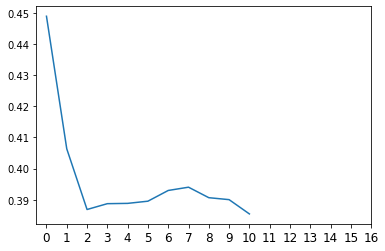

In [121]:
#7. What happens when K=N? Check the model performance on the training and testing data. Here, N=No of data points in the training set.
rmse_val = []
for K in range(1,12):  # used 12 based on 12 variables in the dataset
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(scaled_x_train, y_train)  #fit the model
    pred=model.predict(scaled_x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K-1 , 'is:', error)
   
plt.plot(rmse_val)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],fontsize=12)
plt.show()


We created elbow grapgh and we can clearly see the slope change is maximum at point 2. So we will use k=2

In [122]:
pred = gs.predict(scaled_x_test)
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
rmse_val.append(error) #store rmse values
print('RMSE value for k= ' , gs_results.best_estimator_.n_neighbors , 'is:', error)

RMSE value for k=  10 is: 0.38352844434979055


So based on the grid search we can say the optimum value of RMSE is at k=10 which would give best model prediction

In [123]:
gs_results.best_score_
gs_results.best_estimator_
gs_results.best_params_


{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

RMSE value for k=  0 is: 0.4488792012484348
RMSE value for k=  1 is: 0.4488792012484348
RMSE value for k=  2 is: 0.4488792012484348
RMSE value for k=  3 is: 0.4488792012484348
RMSE value for k=  4 is: 0.4488792012484348
RMSE value for k=  5 is: 0.4488792012484348
RMSE value for k=  6 is: 0.4488792012484348
RMSE value for k=  7 is: 0.4488792012484348
RMSE value for k=  8 is: 0.4488792012484348
RMSE value for k=  9 is: 0.4488792012484348
RMSE value for k=  10 is: 0.4488792012484348


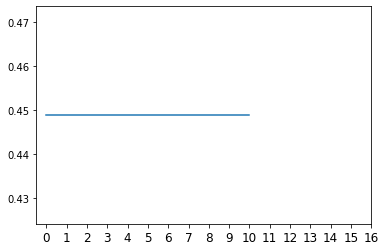

In [124]:
#6. What happens when K=1? Check the model performance on the training and testing data.
rmse_val=[]
for K in range(1,12):  # used 12 based on 12 variables in the dataset
    model = KNeighborsRegressor(n_neighbors = 1)
    model = KNeighborsRegressor(n_neighbors = 1)
    model.fit(scaled_x_train, y_train)  #fit the model
    pred=model.predict(scaled_x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K-1 , 'is:', error)
   
plt.plot(rmse_val)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],fontsize=12)
plt.show()